# Preliminary Analysis

This will document the process of doing preliminary analysis on bandcamp album covers. This is part of an ongoing project which can be found [here](https://www.coeneedell.com/projects/bandcamp_analysis/) and on [github](https://github.com/SoyBison/bandcamp-album-analysis). The goals of this exploration are to look into the viability of using machine learning methods in this setting. Selected methods will be fully automated and utilized for the final analysis. The `'./covers/'` directory was generated from the `album_cover_scrape` function.

In [294]:
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import colorgram
from PIL import Image
import bc_tools as bw
import os
import pickle
from tqdm import tqdm
import colorsys
import string
from copy import copy

The first thing we need to do is figure out a good colorgram size. Let's load a small subset of images.

In [4]:
covers = os.listdir('./covers/')
covers = covers[:10]

imgs = []
dats = []
for cover in covers:
    with open(f'./covers/{cover}', 'rb') as f:
        dat = pickle.load(f)
        imgs.append(dat['cover'])
        dats.append(dat)


In [5]:
def make_colorgram(image_array, n=6):
    img = Image.fromarray(image_array)
    cs = colorgram.extract(img, n)
    cs = [color.rgb for color in cs]
    return cs

A test to see if $n$ colorgrams are close enough to the first $n$ of a $k > n$ colorgram.

In [ ]:
test_range = 30
up_to = 15

test_results = []
big_grams = []
for im in tqdm(imgs):
    big_grams.append(make_colorgram(im, 30))

for i in (range(len(imgs))):
    for n in tqdm(range(up_to)):
        cg = make_colorgram(imgs[i], n)
        test_results.append(cg == big_grams[i][:n])
print(sum(test_results) / len(test_results))

The code aboved returned `1.0`. Doing a quick test like this is easier for me than looking through colorgram.py's implementation and seeing if this is generally true.

Okay so I'll just make generally big colorgrams and trim them down later if I need to. The goal is that these colorgrams mimic the documents in a corpus of _text_, with each color being a word.

In [ ]:
def make_colorgram(image_array, n=6):
    img = Image.fromarray(image_array)
    cs = colorgram.extract(img, n)
    cs = [color.rgb for color in cs]
    return cs


def colorgram_from_file(loc, sink='./colorgrams/', n=40, del_orig=False):
    with open(loc, 'rb') as f:
        album = pickle.load(f)

    cg = make_colorgram(album['cover'], n)
    album.pop('cover', None)
    album['colorgram'] = cg

    if not os.path.exists(sink):
        os.mkdir(sink)

    with open(sink + str(hash(album['url'])), 'wb+') as f:
        pickle.dump(album, f)

    if del_orig:
        os.remove(loc)


def albums_to_colorgrams(source='./covers/', sink='./colorgrams/', n=40, del_orig=True):
    worker = partial(colorgram_from_file, sink=sink, n=n, del_orig=del_orig)
    p = mp.Pool()
    targets = [source + f for f in os.listdir(source)]
    nones = []
    for i in tqdm(p.imap(worker, targets), total=len(targets)):
        nones.append(i)

The above code is run from `bandcamp_webtools.py` to generate the `./colorgrams/` directory.

In [7]:
data_dict = {}
for dat in tqdm(os.listdir('./colorgrams/')):
    with open(f'./colorgrams/{dat}', 'rb') as f:
        packet = pickle.load(f)
        for key in packet:
            try:
                data_dict[key].append(packet[key])
            except KeyError:
                data_dict[key] = [packet[key]]

df = pd.DataFrame(data_dict)
df.head()
            

100%|██████████| 25006/25006 [00:04<00:00, 6164.21it/s]


,title,artist,tags,album,url,store,colorgram
0,Gentrification III: Death and Displacement,Street Sects,"[electronic, industrial metal, metal, noise, p...",gentrification-iii-death-and-displacement,https://streetsects.bandcamp.com/album/gentrif...,streetsects,"[(253, 253, 253), (5, 5, 5), (94, 94, 94), (16..."
1,Looking For Today,The Rare Breed,"[rock, classic rock, doom, grunge, hard rock, ...",looking-for-today,https://ripplemusic.bandcamp.com/album/looking...,ripplemusic,"[(2, 1, 1), (111, 81, 113), (43, 25, 51), (166..."
2,Drum Loops Volume 1,The Polish Ambassador,"[experimental, beat packs, breakbeat, david su...",drum-loops-volume-1,https://thepolishambassador.bandcamp.com/album...,thepolishambassador,"[(246, 229, 155), (9, 34, 46), (55, 115, 85), ..."
3,Destination Infinite,MindSpring Memories,"[80s, 90s, diy, electronic, experimental, avan...",destination-infinite,https://swampcircle.bandcamp.com/album/destina...,swampcircle,"[(251, 224, 243), (246, 246, 196), (101, 240, ..."
4,Osaru no e​.​p. (neji​-​135),Satanicpornocultshop,"[electronic, footwork, ghettotech, juke, juke ...",osaru-no-e-p-neji-135,https://satanicpornocultshop.bandcamp.com/albu...,satanicpornocultshop,"[(248, 241, 231), (56, 43, 26), (127, 85, 55),..."


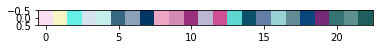

In [169]:
plt.imshow([df['colorgram'][3]])
plt.show()

In [8]:
all_colors = df['colorgram'].values
all_colors = [col for cg in all_colors for col in cg]
print(len(all_colors))
print(len(np.unique(all_colors, axis=0)))

662845
347638


That's probably too many colors for our purposes. Compressing the color grams down to 4-bit channels (12-bit color) will reduce the number of colors to 4096 as opposed to the ~17 million colors which are standard with 24-bit color (8-bits per channel). I'm concerned that with no binning, on a larger dataset color frequencies would not be as apparent. Let's try this out with a 12 bit version and a 15 bit version (32,768 colors)

In [102]:
def rgb_color_converter(col, i=8, o=5):

    in_vals = 2 ** i - 1
    out_vals = 2 ** o - 1
    factor = out_vals / in_vals

    compressed = np.multiply(col, factor)
    compressed = np.round(compressed)
    converted = np.divide(compressed, factor)
    converted = np.round(converted)
    converted = np.int0(converted)

    return converted

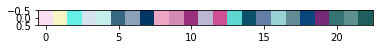

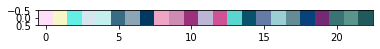

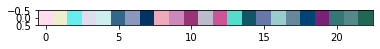

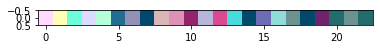

In [170]:
testcolor = df.colorgram[3]
plt.figure()
plt.imshow([testcolor])
plt.figure()
plt.imshow([rgb_color_converter(testcolor, o=5)])
plt.show()
plt.imshow([rgb_color_converter(testcolor, o=4)])
plt.show()
plt.imshow([rgb_color_converter(testcolor, o=3)])
plt.show()


The colors stay pretty recognizable all the way down to 3-bits per channel. We're mostly losing nuance in the grays and intermediate colors. That being said, we'll still try the LDA analysis with both 5 bit channels and 4 bit channels. In general things get a little more obnoxious, louder, but we shouldn't lose too mucch information.

In [181]:
df['colorgram15'] = df['colorgram'].apply(rgb_color_converter)
df['colorgram12'] = df['colorgram'].apply(rgb_color_converter, args=(8, 4))

In [183]:
all_colors = df['colorgram15'].values
all_colors = [col for cg in all_colors for col in cg]
print(len(np.unique(all_colors, axis=0)))
all_colors = df['colorgram12'].values
all_colors = [col for cg in all_colors for col in cg]
print(len(np.unique(all_colors, axis=0)))

21859
3935


In the 15-bit case we now have ~22 thousand unique colors and in the 12-bit case we have 3935 unique colors. These are much more managable "lexicon" sizes for the kind of analysis we need to do. Here's the tricky part though. Latent Dirichlet Allocation is traditionally only used for text analysis. Because of this, the `sklearn` implementation of this algorithm only works on strings. So we're going to need to make a function that converts our colors to strings. We'll just use the standard hexadecimal representation.

In [230]:
def rgb2str(col):
    raw_hexes = [hex(c) for c in col]
    cleanhex = [c[2:].rjust(2, '0') for c in raw_hexes]
    return ''.join(cleanhex)

def str2rgb(col):
    assert len(col) == 6
    hexes = [col[i:i + 2] for i in range(0, 6, 2)]
    nums = tuple([int(h, 16) for h in hexes])
    return nums

def cg2doc(cg):
    cols = map(rgb2str, cg)
    return ' '.join(cols)

def doc2cg(doc):
    hexes = doc.split(' ')
    return [str2rgb(col) for col in hexes]

In [227]:
print(cg2doc(df['colorgram'][1][:10]))
print(cg2doc(df['colorgram15'][1][:10]))
print(cg2doc(df['colorgram12'][1][:10]))

020101 6f5171 2b1933 a698ac efefef 1a1225 d5ced8 522f55 795951 e1dee5
000000 6b5273 291931 a594ad efefef 191021 d6ced6 523152 7b5a52 dedee6
000000 775577 331133 aa99aa eeeeee 221122 ddccdd 553355 775555 dddddd


When you change it to a hex representation, the effect of lowering the bit depth is more obvious. Technically this representation of the colors is still 24-bits, but we just rounded each color to the nearest color (rgb-channel-wise) in the standard 15 and 12-bit palettes. We also could've rounded along other representations like HLS, but rgb is the simplest for this case.

In [231]:
x_15 = df['colorgram15'].apply(cg2doc)
x_12 = df['colorgram12'].apply(cg2doc)


In [318]:
def get_topics(model, n_feats=8):
    feat_names = model['c_vec'].get_feature_names()
    comps = model['lda'].components_
    top_comps = [topic.argsort()[:-n_feats-1:-1] for topic in comps]

    f = np.vectorize(lambda x: feat_names[x])

    str_tops = f(top_comps)

    outmat = []
    for row in str_tops:
        outtop = []
        for col in row:
            outtop.append(str2rgb(col))
        outmat.append(sorted(outtop, key=lambda rgb: colorsys.rgb_to_hls(*rgb)))


    return outmat

Since topic modeling is so sensitive to the number of components, and it's difficult to tune unsupervised learning techniques, we will have to run the topic modeling system repeatedly and look at the topics in order to pick a "best" `n_components` hyperparameter. Note that in these images the colors aren't sorted by "dominance". The most dominant colors in the topic are sorted by Hue, Luminosity, and Saturation.

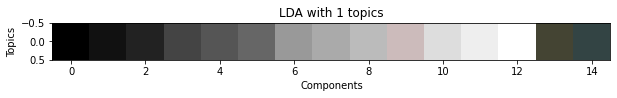

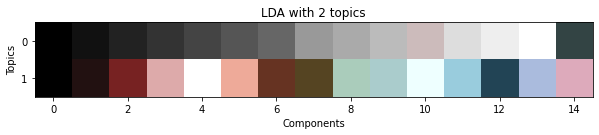

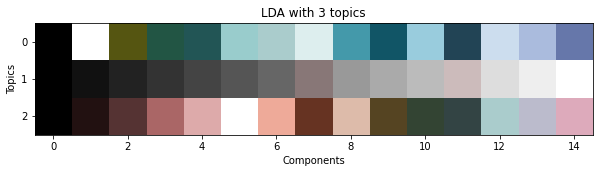

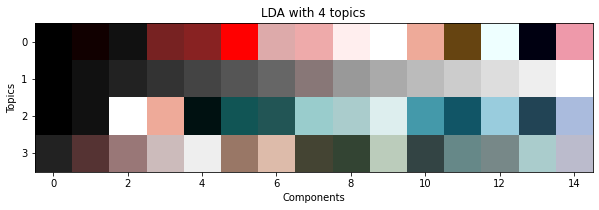

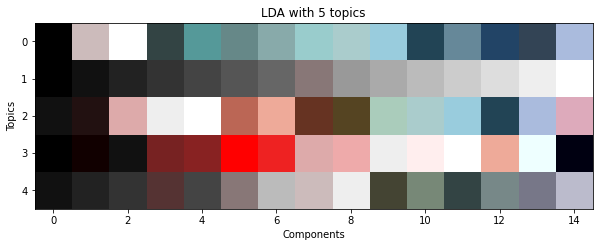

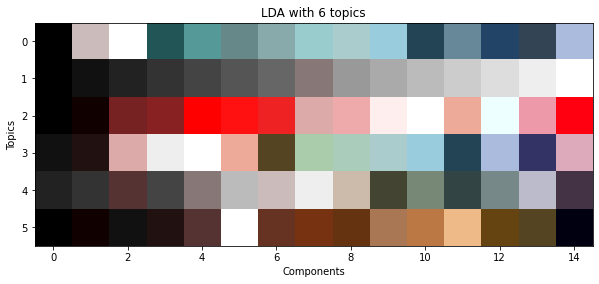

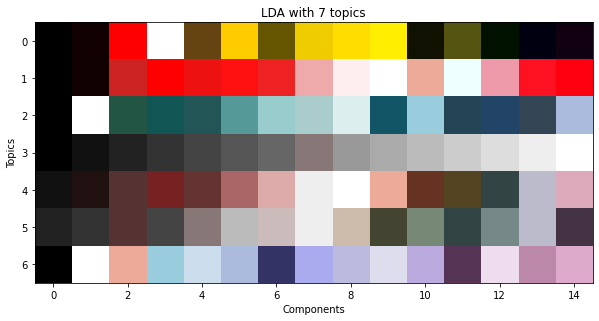

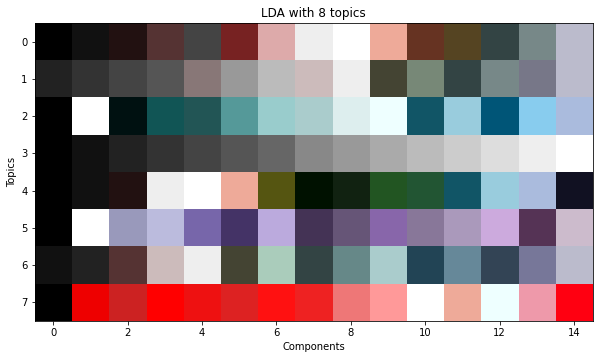

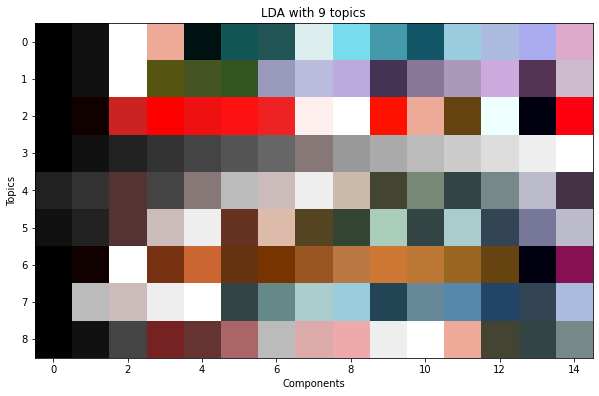

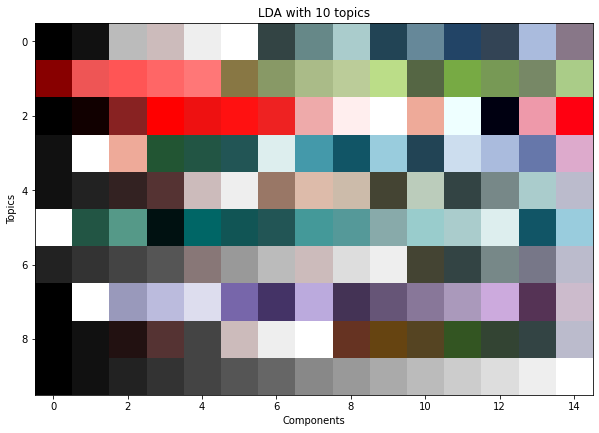

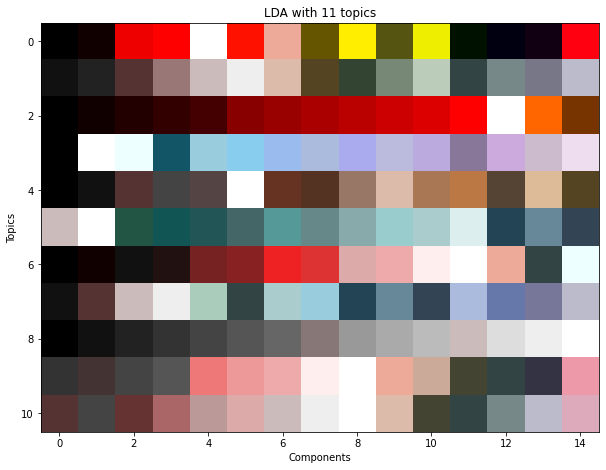

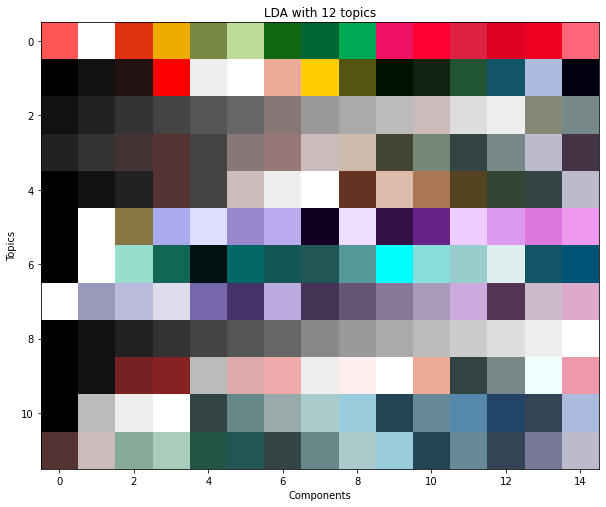

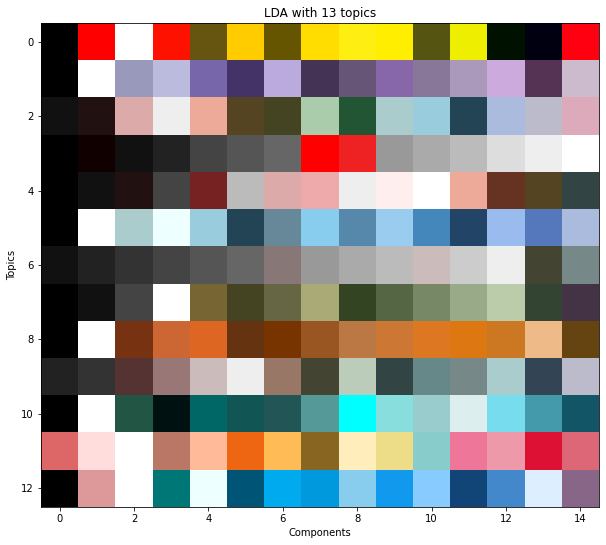

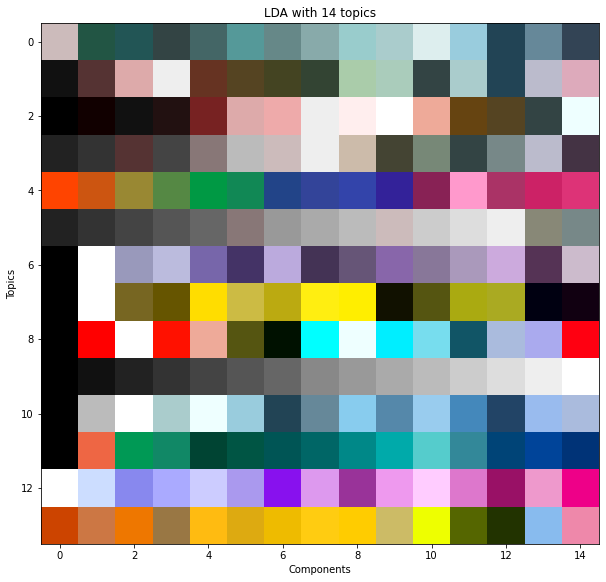

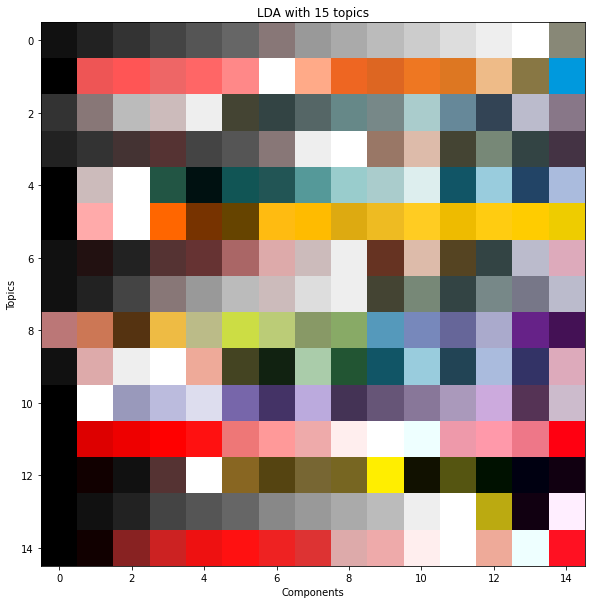

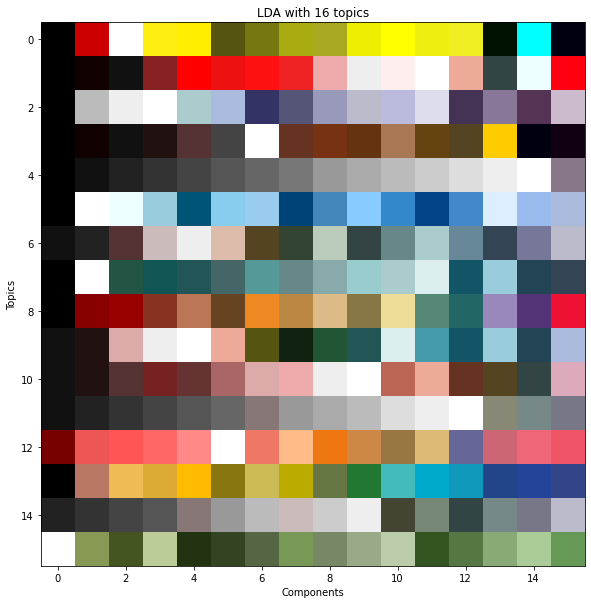

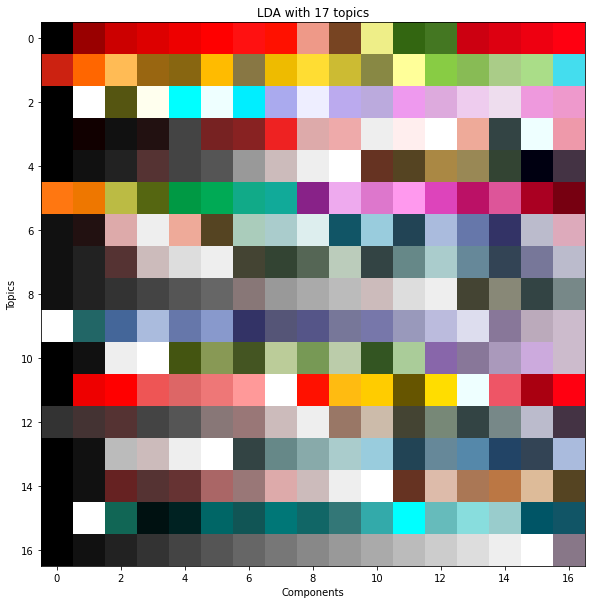

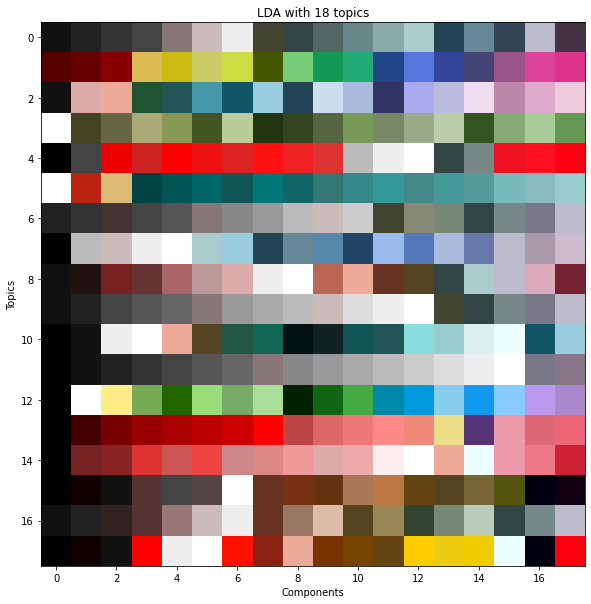

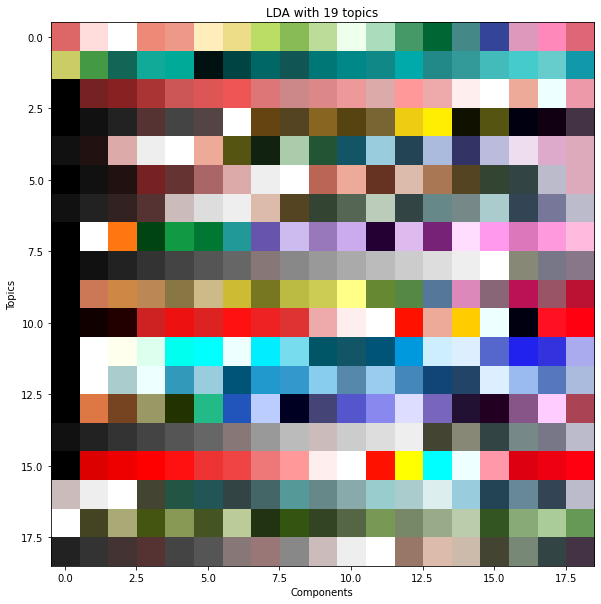

In [327]:
for n in range(1, 20):
    lda_12 = Pipeline([
        ('c_vec', TfidfVectorizer()),
        ('lda', LatentDirichletAllocation(n_components=n, n_jobs=-1))
    ])

    lda_12.fit_transform(x_12)
    plt.figure(figsize=(10, 10))
    plt.imshow(get_topics(lda_12, n_feats=max(15, n)))
    plt.title(f'LDA with {n} topics')
    plt.xlabel('Components')
    plt.ylabel('Topics')
    plt.show()

Now let's take a look at the 15-bit case.

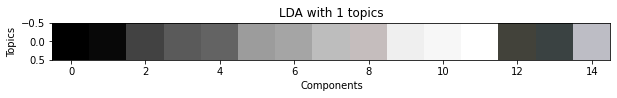

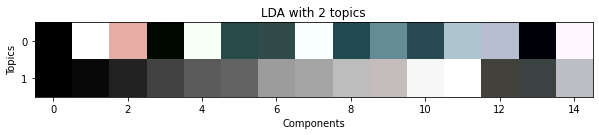

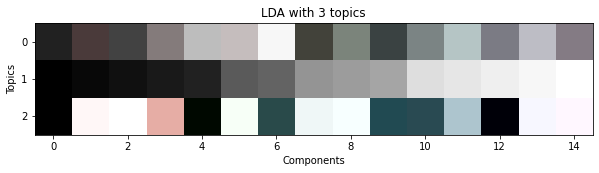

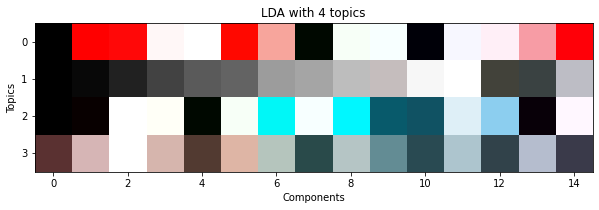

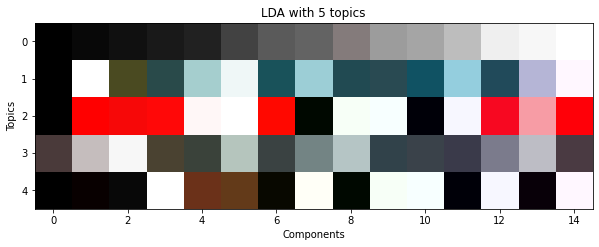

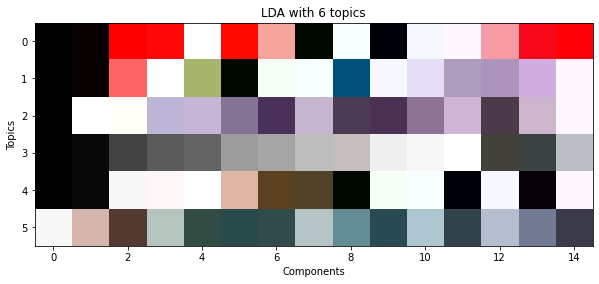

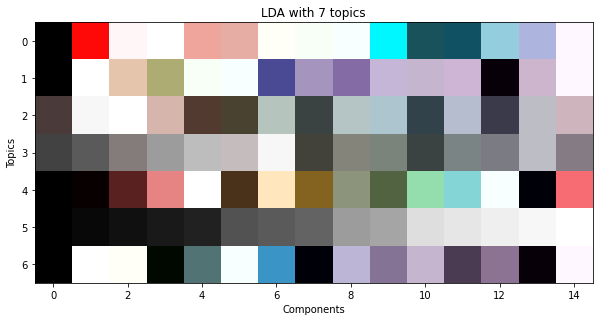

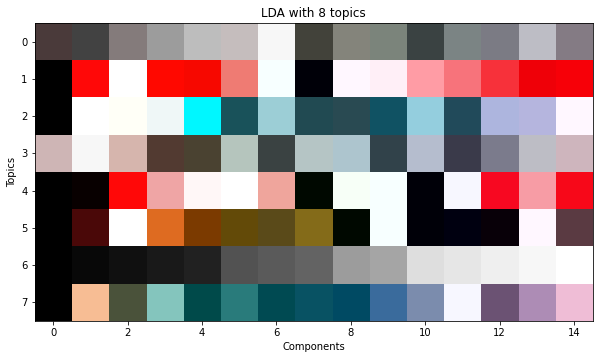

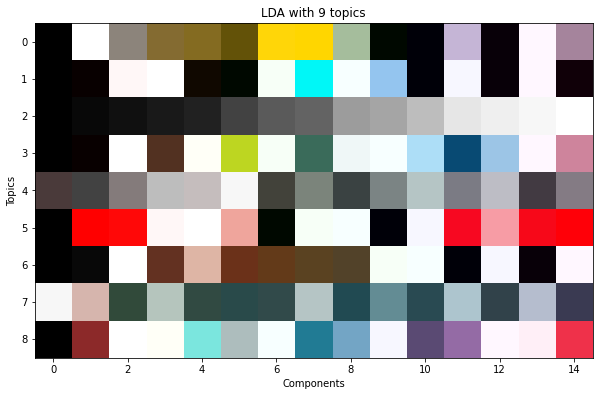

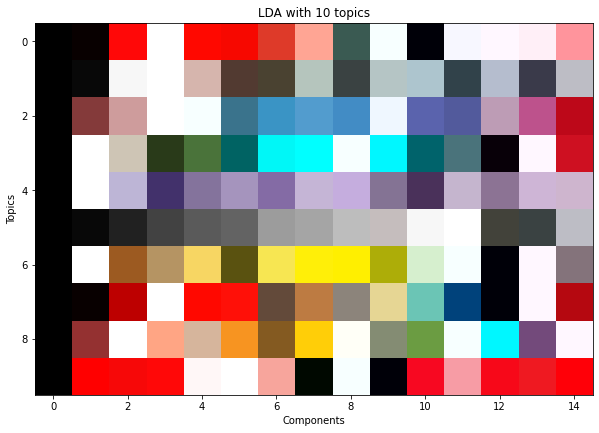

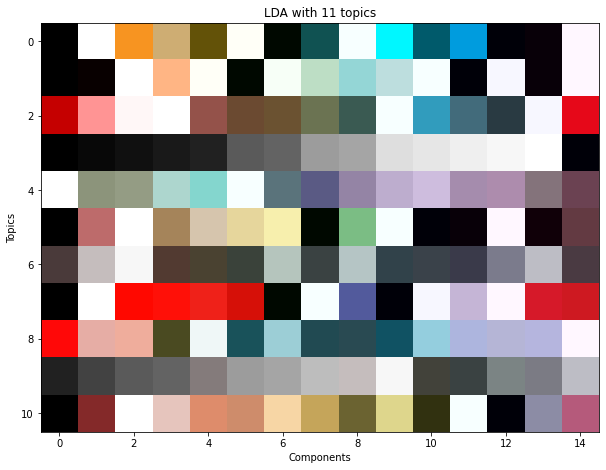

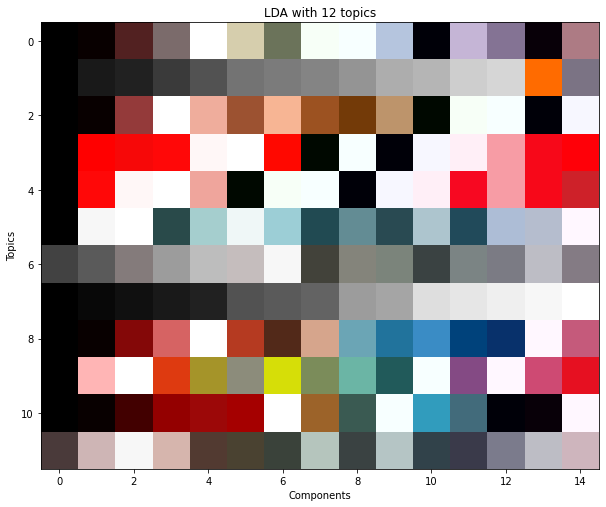

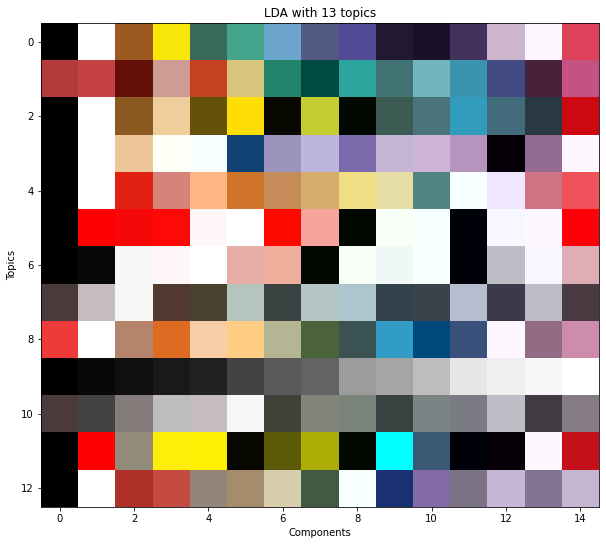

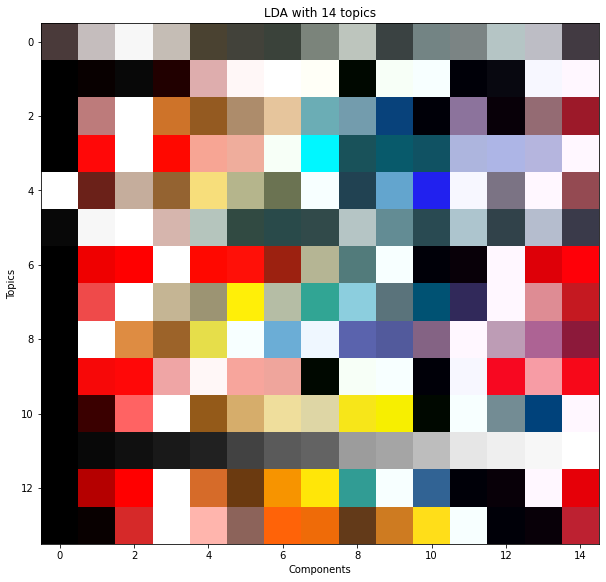

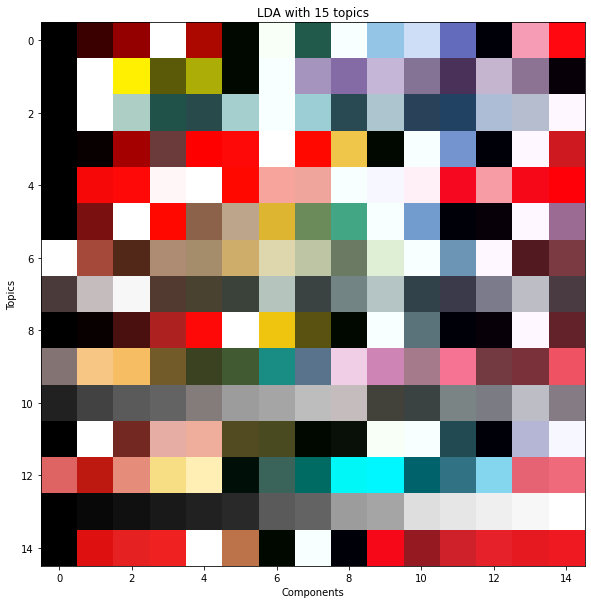

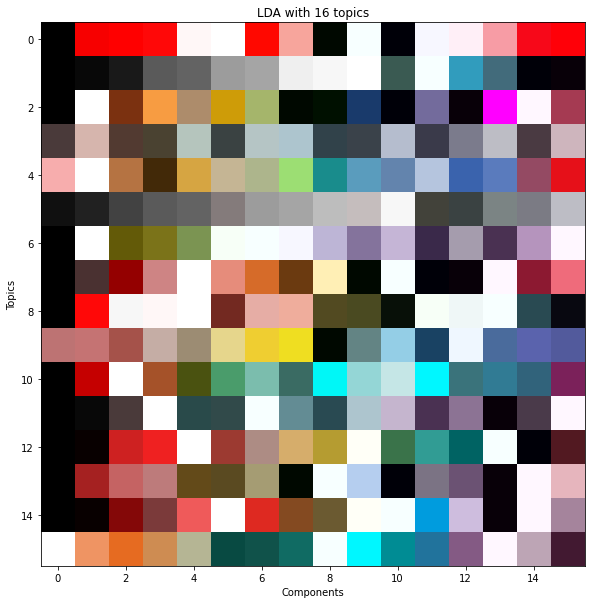

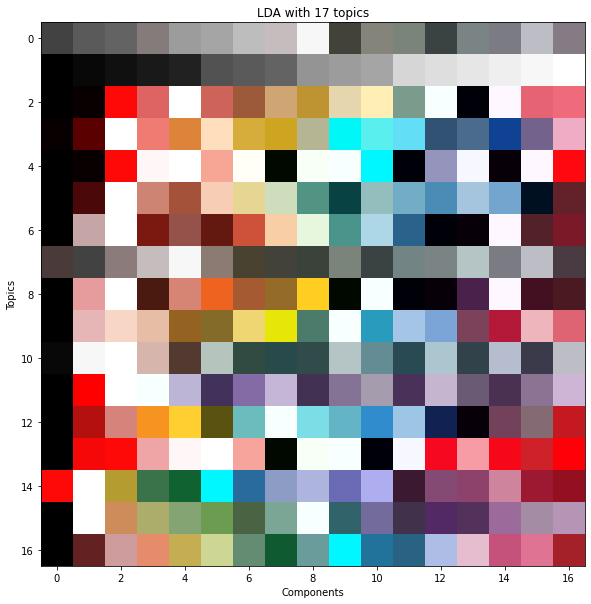

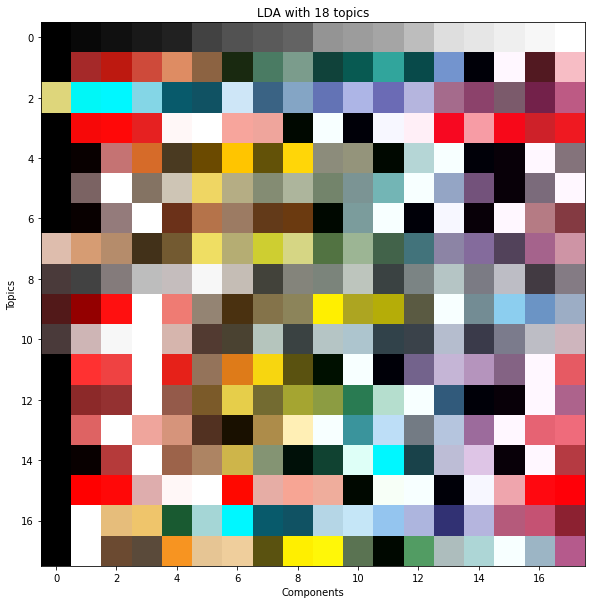

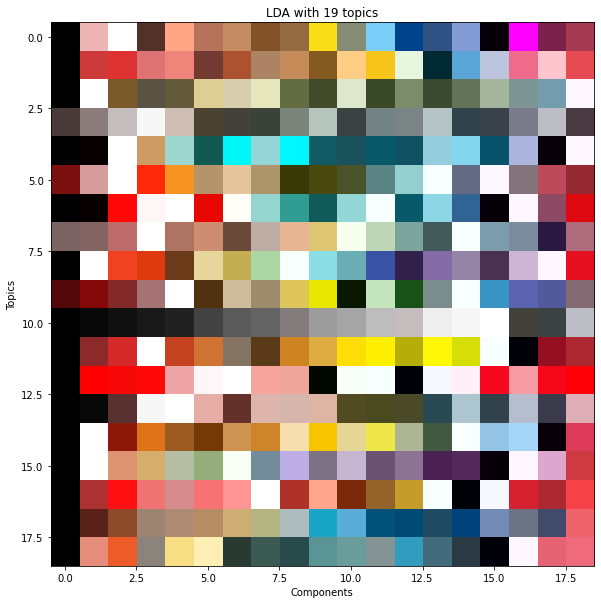

In [330]:
for n in range(1, 20):
    lda_15 = Pipeline([
        ('c_vec', TfidfVectorizer()),
        ('lda', LatentDirichletAllocation(n_components=n, n_jobs=-1))
    ])

    lda_15.fit_transform(x_15)
    plt.figure(figsize=(10, 10))
    plt.imshow(get_topics(lda_15, n_feats=max(15, n)))
    plt.title(f'LDA with {n} topics')
    plt.xlabel('Components')
    plt.ylabel('Topics')
    plt.show()

The 12-bit case works so much better than the 15 bit case that it might be worth considering trying a 9-bit case (512 colors).

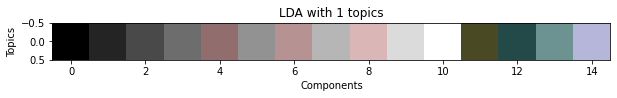

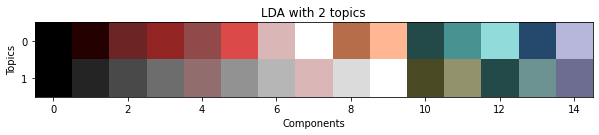

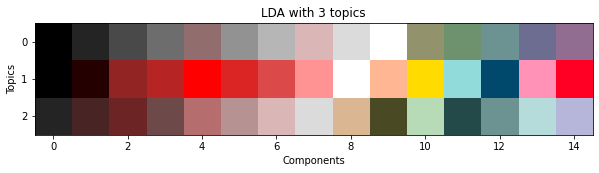

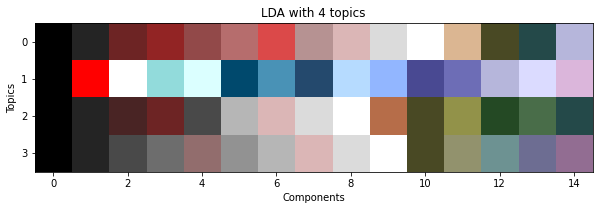

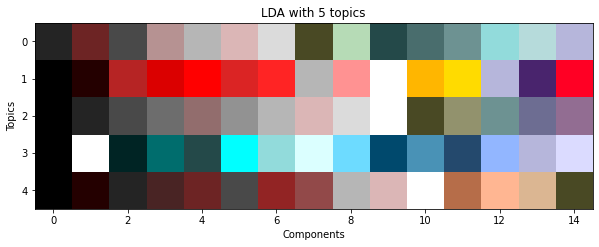

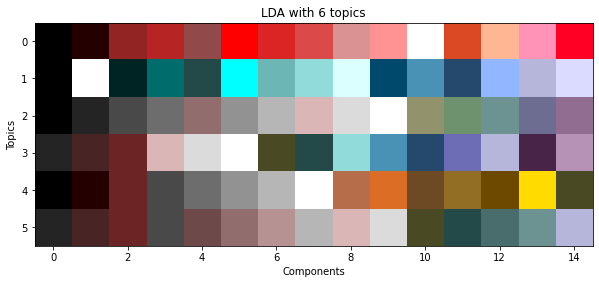

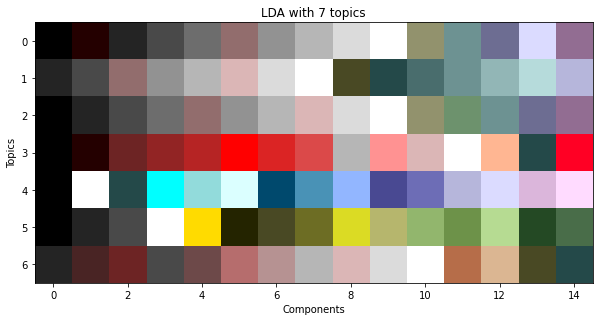

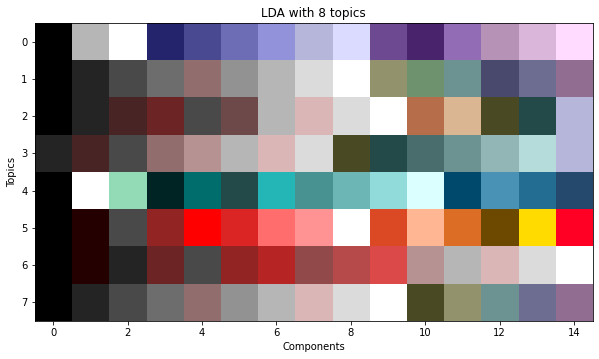

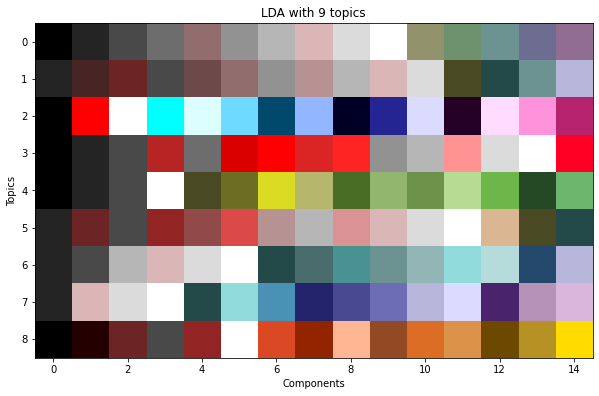

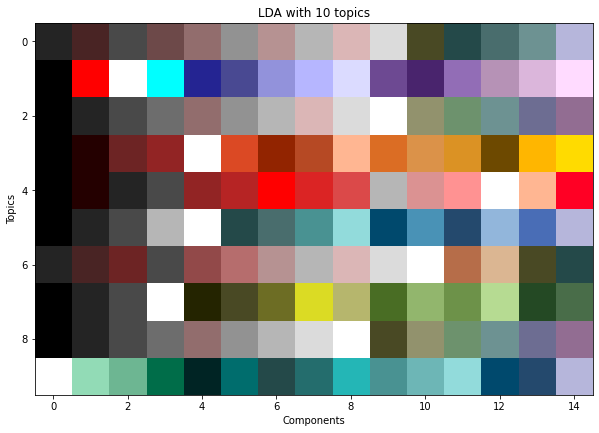

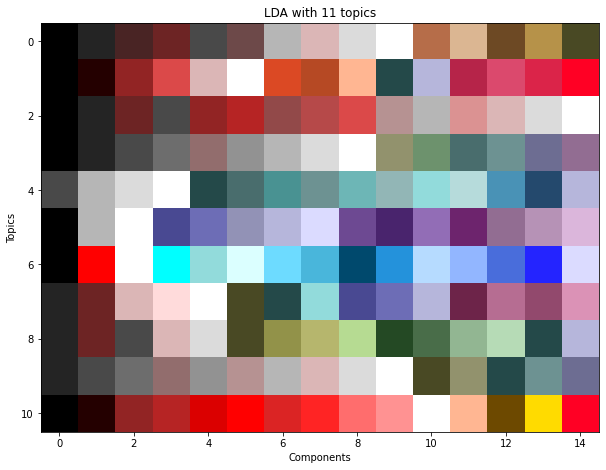

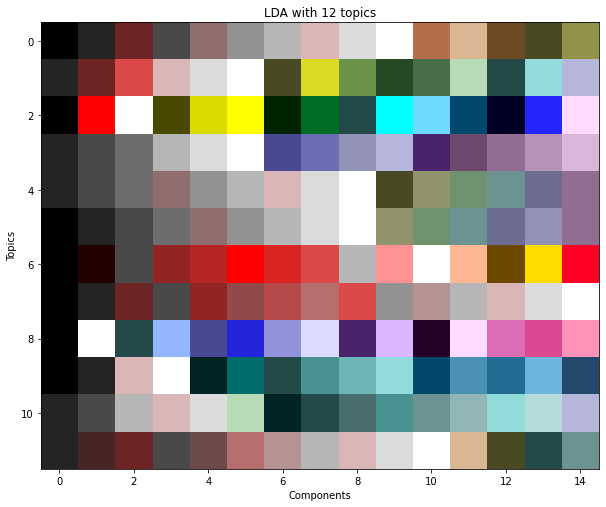

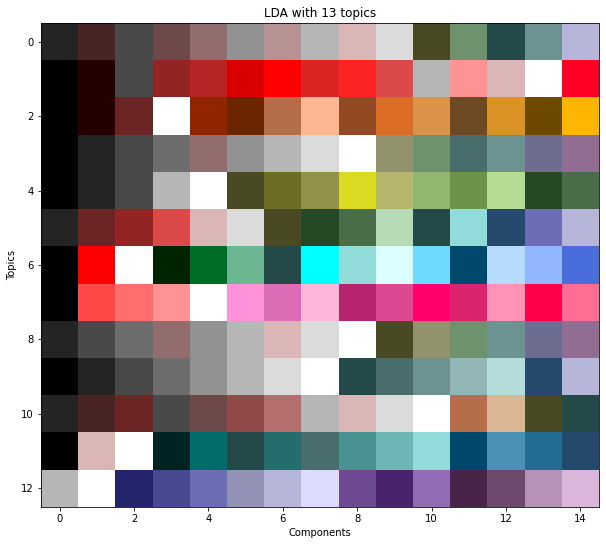

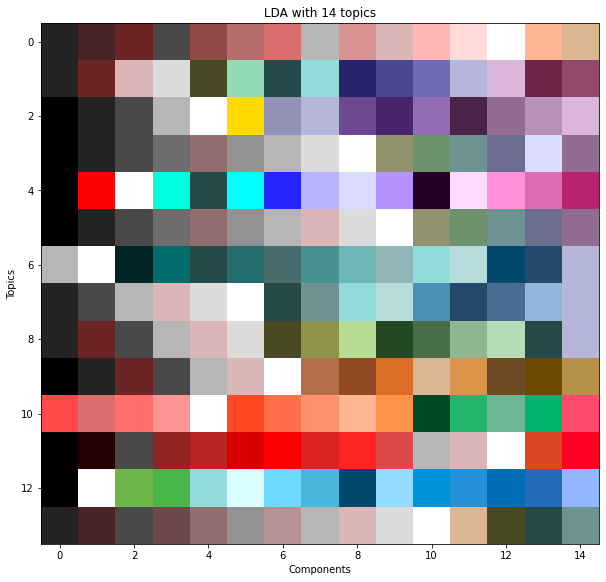

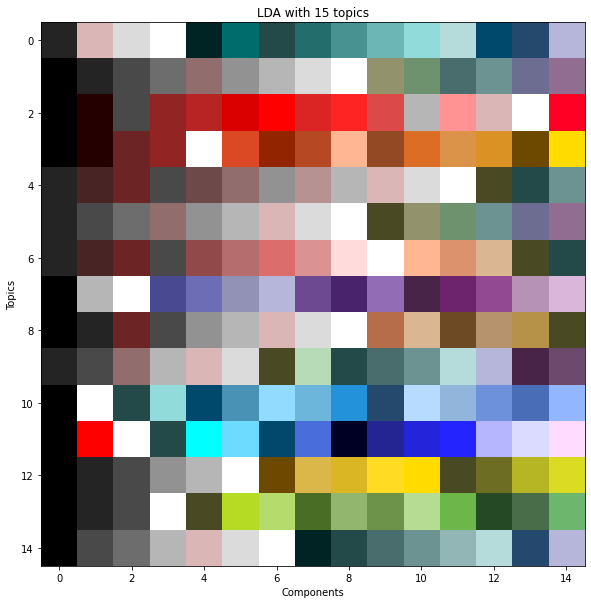

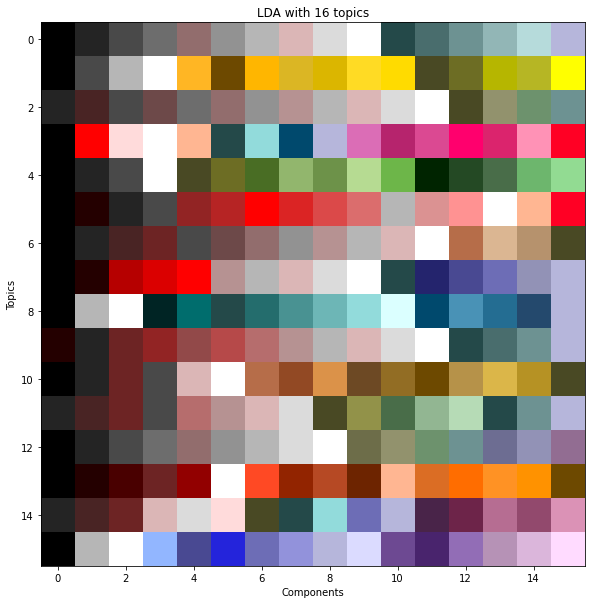

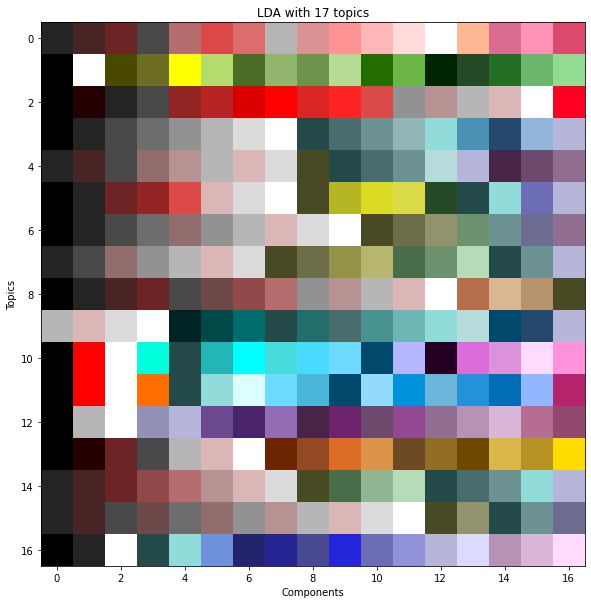

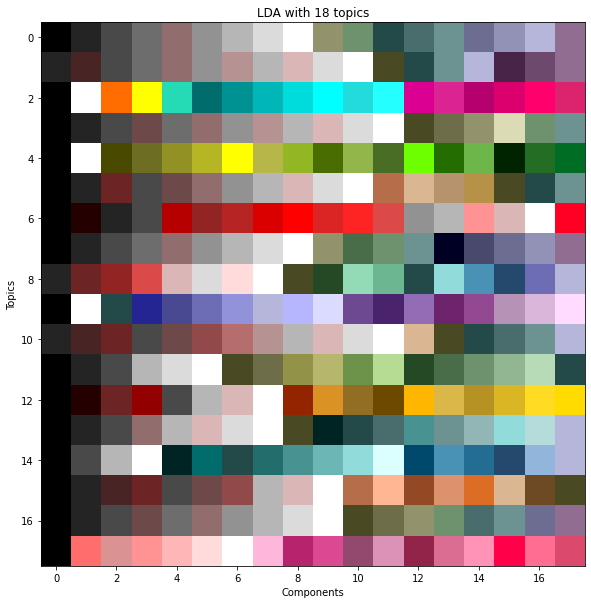

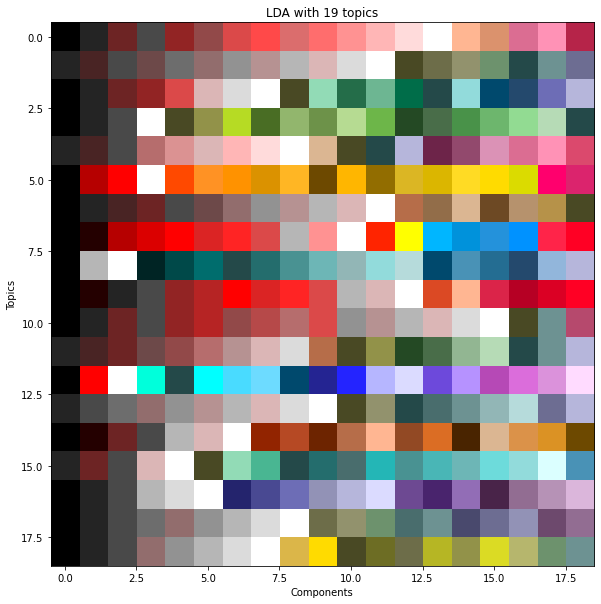

In [331]:
df['colorgram9'] = df['colorgram'].apply(rgb_color_converter, args=(8, 3))
x_9 = df['colorgram9'].apply(cg2doc)

for n in range(1, 20):
    lda_9 = Pipeline([
        ('c_vec', TfidfVectorizer()),
        ('lda', LatentDirichletAllocation(n_components=n, n_jobs=-1))
    ])

    lda_9.fit_transform(x_9)
    plt.figure(figsize=(10, 10))
    plt.imshow(get_topics(lda_9, n_feats=max(15, n)))
    plt.title(f'LDA with {n} topics')
    plt.xlabel('Components')
    plt.ylabel('Topics')
    plt.show()

Okay so we should use 12-bit. Although using 9-bit color does make it easier for the system to identify similar colors, there's a loss of nuance in some of these topics that makes it difficult to tell some of the topics apart. For the final analysis, we should use Latent Dirichlet Allocation with a larger dataset and 12-bit color depth colorgrams. I'll have to write new scraping algorithms that can handle the large load, and run on the datasets in a more automated way. We should probably use 18 topics sincce it made for better decompositions in this subset. 